In [55]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.datasets import fashion_mnist
import random

In [29]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [95]:
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

In [96]:
train_images.shape

(60000, 28, 28)

In [97]:
train_images[0].dtype

dtype('uint8')

In [98]:
train_images=train_images.astype(dtype='float32')
test_images=test_images.astype(dtype='float32')


In [99]:
train_images=train_images/255
test_images=test_images/255

In [100]:
def create_pairs(images,digit_indices):
  pairs=[]
  labels=[]
  n=min([len(digit_indices[d]) for d in range(10)])-1

  for d in range(10):
    for i in range(n):
      z1,z2=digit_indices[d][i],digit_indices[d][i+1]
      pairs+=[[images[z1],images[z2]]]
      inc=random.randrange(1,10)
      dn=(d+inc)%10
      z1,z2=digit_indices[d][i],digit_indices[dn][i]
      pairs+=[[images[z1],images[z2]]]
      labels+=[1,0]

  return np.array(pairs),np.array(labels)

In [101]:
def create_pairs_on_set(images,labels):
  digit_indices=[np.where(labels==i)[0] for i in range(10)]
  pairs,y=create_pairs(images,digit_indices)
  y=y.astype('float32')

  return pairs,y

In [102]:
tr_pairs,tr_y=create_pairs_on_set(train_images,train_labels)
ts_pairs,ts_y=create_pairs_on_set(test_images,test_labels)

In [103]:
tr_pairs.shape

(119980, 2, 28, 28)

In [104]:
ts_pairs.shape

(19980, 2, 28, 28)

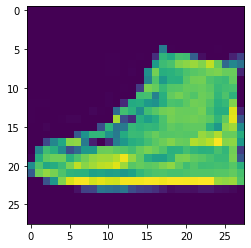

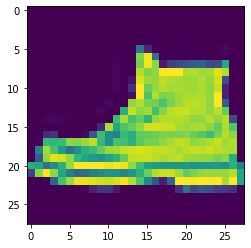

1.0


In [105]:
this_pair=119000

plt.imshow(tr_pairs[this_pair][0])
plt.grid(False)
plt.show()
plt.imshow(tr_pairs[this_pair][1])
plt.grid(False)
plt.show()

print(tr_y[this_pair])

In [106]:
def initialize_base_network():
  input=Input(shape=(28,28,),name='base_input')
  x=Flatten(name='flatten_input')(input)
  x=Dense(128,activation='relu',name='first_base_dense')(x)
  x=Dropout(0.1,name='first_dropout')(x)
  x=Dense(128,name='second_base_dense')(x)
  x=Dropout(0.1,name='second_dropout')(x)
  x=Dense(128,name='third_base_dense')(x)

  return Model(inputs=input,outputs=x)


In [107]:
from tensorflow.keras import backend as K

In [108]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

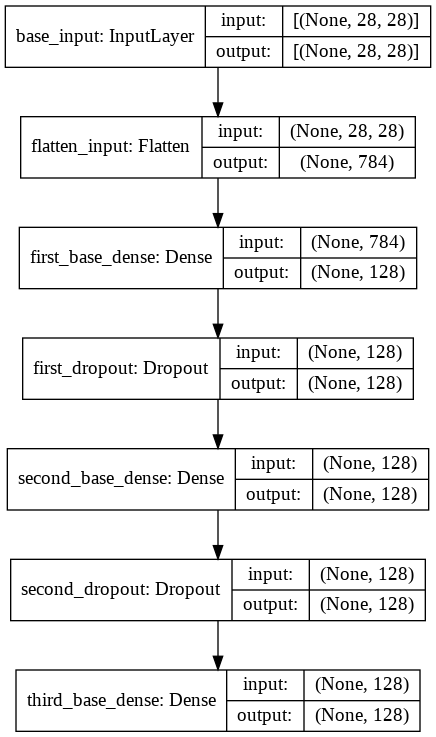

In [109]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

In [110]:
from tensorflow.keras.layers import Lambda

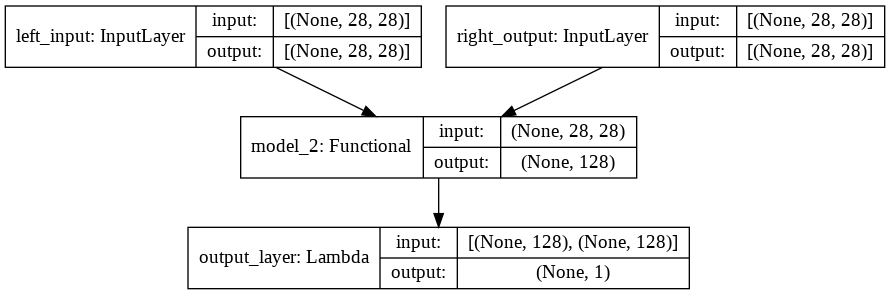

In [111]:
input_a=Input(shape=(28,28,),name='left_input')
vector_output_a=base_network(input_a)

input_b=Input(shape=(28,28,),name='right_output')
vector_output_b=base_network(input_b)

output=Lambda(euclidean_distance,output_shape=eucl_dist_output_shape,name='output_layer')([vector_output_a,vector_output_b])

model=Model(inputs=[input_a,input_b],outputs=output)

plot_model(model,show_shapes=True,show_layer_names=True,to_file='outer_model.png')

In [112]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [113]:
from tensorflow.keras.optimizers import RMSprop

In [114]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 8s 8ms/step - loss: 0.1739 - val_loss: 0.1157
Epoch 2/20
938/938 [==============================] - 7s 7ms/step - loss: 0.1282 - val_loss: 0.1155
Epoch 3/20
938/938 [==============================] - 6s 7ms/step - loss: 0.1161 - val_loss: 0.1029
Epoch 4/20
938/938 [==============================] - 6s 7ms/step - loss: 0.1071 - val_loss: 0.1046
Epoch 5/20
938/938 [==============================] - 7s 7ms/step - loss: 0.1018 - val_loss: 0.1008
Epoch 6/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0987 - val_loss: 0.1124
Epoch 7/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0964 - val_loss: 0.0939
Epoch 8/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0945 - val_loss: 0.0878
Epoch 9/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0932 - val_loss: 0.0891
Epoch 10/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0924 - val_loss: 0.0893

In [115]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [116]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step - loss: 0.0820
Loss = 0.08200008422136307, Train Accuracy = 0.9185364227371229 Test Accuracy = 0.8994494494494495


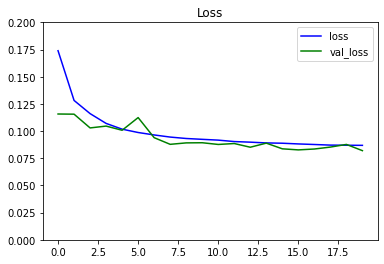

In [118]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [119]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

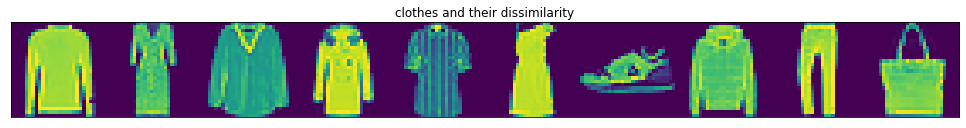

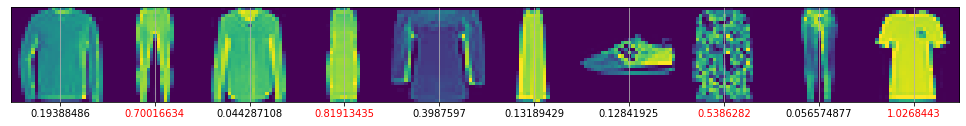

In [120]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)